##  $$\color{blue}{\text{MIT 2.131 Wiener Nonlinear System ID: Cuber}} $$

#### <center> Ian Hunter, 18 April 2022

Version Notes:   
- 13 Apr 2022 Started
- 17 Apr 2022 Fixed sluggish performance problem with plotting n(.) 
- 18 Apr 2022 Changed to use interpolate for function inversion (much faster)
- 18 Apr 2023 Updated

#### Objectives

The purpose of these notes is to define Wiener systems and introduce techniques which under certain circumstances enables Wiener systems to be characterized experimentally.

#### Wiener Systems

A linear dynamic subsystem followed by a static nonlinearity (e.g., cuber, hard limiter, etc) is called a Wiener system after Norbert Wiener (see https://en.wikipedia.org/wiki/Norbert_Wiener), the MIT mathematician who developed a number of system identification techniques. Wiener systems should not be confused with Wiener kernel nonlinear system representations. 

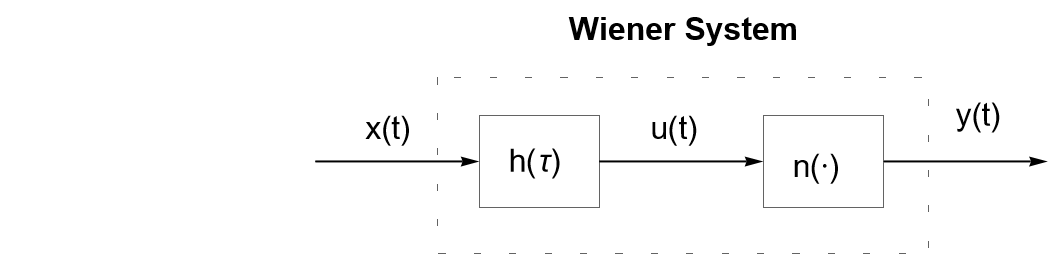

Here we see a Wiener system consisting of a linear dynamic subsystem as represented by an impulse response function, $h(\tau)$, followed by a static nonlinear element, $n(\centerdot)$. The input to the Wiener system is denoted by, $x(t)$, and the output from the Wiener system is denoted by, $y(t)$. An internal signal $u(t)$ is the output from the linear dynamic component, $h(\tau)$, and is also the input to the static nonlinear element, $n(\centerdot)$.

Sometimes Wiener systems are called LN systems because there is a linear dynamic system (L) followed by a static nonlinearity (N). An NL system consists of a nonlinear static element (N) followed by a linear dynamic element (L) and is called a Hammerstein system. Hammerstein system identification is the subject of other notes.

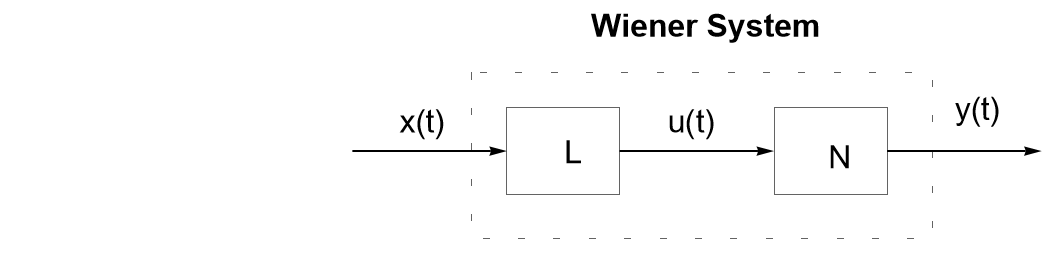

In these notes we will simulate a Wiener system and attempt to discover, $h(\tau)$, and $n(\centerdot)$ purely from the input, $x(t)$, and output, $y(t)$, data sets.

#### Import libraries

We will use the Python plotting library, matplotlib, as well as the library of numeric math functions, numpy, and the library of scientific numerical algorithms, scipy.

In [1]:
import numpy as np # works with complex but one of the arguments must be complex
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate
from scipy.linalg import toeplitz, solve_toeplitz
from numpy.polynomial.polynomial import polyfit
import csv # this gives us tools to manipulate CSV files
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # this is key to improving plot resolution

#### Create Wiener system

Lets choose a second-order low-pass  subsystem. The general  transfer function  for such a  sub system is :

$$ \large H(s)=\frac{\alpha.{\omega_n}^2}{s^2+2.\zeta.\omega_n.s+{\omega_n}^2} $$

If we inverse Laplace transform this transfer function then we get the impulse response function:

$$ \large h(\tau)=\frac{e^{-\tau.\zeta.\omega}.\alpha .\omega .sinh\bigl(\tau.\sqrt{{\zeta}^2-1}.\omega\bigr)}{\sqrt{{\zeta}^2-1}} $$

where $\alpha $ is the static gain, $\omega$ is the natural frequency in rad/s and $\zeta$ is the damping parameter.

The Python code to implement this second-order impulse response function (IRF) is: 

In [ ]:
def irf2(tau,a,w,z): # 2nd order impulse response function
    # where a is the static gain
    #       w is the natural frequency in rad/s
    #       z is the dampling parameter
    # note that complex is required to force np.sqrt to return a complex number
    c=np.sqrt(complex(z**2-1.0))
    return np.real((np.exp(-tau*z*w)*a*w*np.sinh(tau*c*w))/c)

Lets make the static gain, $\alpha=1$, the natural frequency, $\omega_n=2.\pi.10$ (radians/s) = $10 Hz$, and the damping parameter, $\zeta=0.3$ :

In [ ]:
a=2
w=2*np.pi*10
z=0.3

We need a sampled version of this IRF. So lets make the sampling rate 2 kHz (i.e., sampling increment, dt, 0.5 ms) and impulse response function length of 0.5 second:

In [ ]:
dt=0.0005 # 0.5 ms
mi=1000
tau=np.arange(0,dt*mi,dt)

In [ ]:
h=irf2(tau,a,w,z)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.plot(tau, h, 'r.',markersize=1)
plt.title('2nd-Order IRF')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

It is always a good idea to plot the individual points in the impulse response function to check that the sampling rate is high enough given the time course of the function. It is best to have plenty of points (e.g., > 10) covering the initial rise of the impulse response function. It is also best to have a domain whose duration (last value) is 1.5 x to 2 x the time it takes for the impulse response to "die out". If these conditions are not met then resample the original continuous (symbolic) impulse response function with a more appropriate sampling interval, dt.

We can check (via trapezoidal integration) to see if the area under this sampled IRF equals the static gain, $\alpha$:

In [ ]:
np.trapz(h,tau)

This is close enough.

#### Cuber static nonlinearity, $n(\centerdot)$

In these notes we will make the Wiener system static nonlinearity a cuber with an offset of c0=2 and a cube term with a scaling factor of c3=5:

In [ ]:
def n(u,c):  # c[0] + c[1]*u + c[2]*u**2 + c[3]*u**3 + ....+ c[i]*u**i
    i=0
    sum=0
    while i<len(c):
        sum=sum+c[i]*u**i
        i=i+1
    return sum

In [ ]:
plt.rcParams['figure.figsize'] = [8, 7]
u1=np.arange(-2,2,0.01)
plt.plot(u1,n(u1,[2,0,0,5]), 'r,',markersize=1)
plt.title('Cuber Static Nonlinearity, n(.)')
plt.xlabel('Amplitude')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

#### Generate Gaussian white noise signal, x(t)

We start by generating 50 seconds of a Gaussian white noise input, x(t), with a mean of 0 and a standard deviation of 1. Note that we could have used pretty much any stochastic input here except a stochastic binary input (which is not sufficient to identify a nonlinear system). 

In [ ]:
ni=100000 # number of input samples
t=np.arange(0,ni*dt,dt)
[ni,ni*dt]

In [ ]:
x=np.random.randn(ni) # Gaussian numbers

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, x, 'r',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input Signal, x(t)')
plt.grid()
plt.show()

#### Convolve, $h(\tau)$, with $x(t)$ to produce, $u(t)$

We now numerically convolve our input, $x(t)$, with the impulse response function, $h(\tau)$, to generate the internal signal, $u(t)$:

In [2]:
# edit 5/15
from numpy import loadtxt
dt = 0.012
h = loadtxt('h.csv', delimiter=',',usecols = (0))
xtemp = loadtxt('2.131 DMA Data/Gaussian/Dgauss-1730.csv', delimiter=',',usecols = (1))
ytemp = loadtxt('2.131 DMA Data/Gaussian/Fgauss-1730.csv', delimiter=',',usecols = (1))
ni = x.size
mi = x.size
#if ytemp.size > xtemp.size:
#    y = ytemp[:(xtemp.size)]
#    x = xtemp
#    u = utemp
#else:
#    x = xtemp[:(ytemp.size)]
#    u = utemp[:(ytemp.size)]
#    y = ytemp
x = xtemp[1016:100500]
y = ytemp[1016:100500]
#

u=dt*np.convolve(x,h)[0:ni] # need just the first ni values

FileNotFoundError: h.csv not found.

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, u, 'g',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Intermediate Signal, u(t)')
plt.grid()
plt.show()


#### Generate output, $y(t)$

We now pass $u(t)$ through our static nonlinearity, $n(\centerdot)$, to produce an output to which we add 5% measurement noise, $e(t)$, to produce $y(t)$:

In [ ]:
yvar=np.var(n(u,[2,0,0,5]))
evar=np.var(np.random.randn(ni))
y=n(u,[2,0,0,5])+(0.1*yvar/evar)*np.random.randn(ni) # add 10% Gaussian white measurement noise

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signal, y(t)')
plt.grid()
plt.show()

Notice that the output has a non-zero mean.

#### Compare input and output probability density functions 

We now calculate the input and output probability density functions:

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True) 
plt.rcParams['figure.figsize'] = [8, 8]
xmean=np.mean(x)
xsd=np.std(x)
ampl=np.arange(-10,10,0.01)
xpdf=np.exp(-0.5*((ampl-xmean)/xsd)**2)/(xsd*np.sqrt(2*np.pi))
ax1.plot(ampl,xpdf, 'r',linewidth=1)
ax1.hist(x, density=True, bins=100, color='b') 
ax1.set(xlabel='Amplitude (V)', ylabel='Probability Density', title='Input (x) Probability Density')
#ax1.grid()
ymean=np.mean(y)
ysd=np.std(y)
ampl=np.arange(-10,10,0.01)
ypdf=np.exp(-0.5*((ampl-ymean)/ysd)**2)/(ysd*np.sqrt(2*np.pi))
ax2.plot(ampl,ypdf, 'r',linewidth=1)
ax2.hist(y, density=True, bins=400, color='b')
ax2.set(xlabel='Amplitude (V)', ylabel='Probability Density', title='Output (y) Probability Density')
#ax2.grid()
plt.tight_layout()
plt.xlim([-5,5])
plt.show()
plt.clf()
plt.close()

The output, $y(t)$, is clearly non-Gaussian.

A linear system perturbed by a Gaussian stochastic input (does not need to be white) will produce a Gaussian stochastic output. If the output from a system driven by a Gaussian stochastic input is non Gaussian (as here) then this is clear evidence that the system is nonlinear.

#### Wiener System Identification

We now ask if it is possible to determine the two internal subsystems, namely, $h(\tau)$ and $n(\centerdot)$ solely from the input, $x(t)$, and output, $y(t)$, signals.
Lets see what happens when we compute the nonparametric impulse response function, $h1(\tau)$, between the input, $x(t)$, and the output, $y(t)$. 

As detailed in previous notes we can determine the system impulse response function from estimates of the input auto-correlation and input output cross-correlation functions via Toeplitz matrix inversion:

In [ ]:
cxx=dt*signal.correlate(x-np.mean(x),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # x auto-correlation
cyx=dt*signal.correlate(y-np.mean(y),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # xy cross-correlation
toe=toeplitz(cxx)
h1=solve_toeplitz(cxx,cyx)/dt

Note that we removed the mean from both x and y in calculating cxx and cyx.

In [ ]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.plot(tau, h, 'r.',markersize=1)
plt.plot(tau, h1, 'b.',markersize=1)
plt.title('h and h1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

If we multiply $h(\tau)$ by $\beta$ and divide  $n(\centerdot)$ by $\beta$ there will be no change in the output, $y(t)$. In other words there is a scaling constant, $\beta$ , that can freely move from $h(\tau)$ to $n(\centerdot)$. So lets scale $h(\tau)$ and $h1(\tau)$ so that the area under them is 1 and replot:

In [ ]:
np.trapz(h,tau)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.plot(tau, h/np.trapz(h,tau), 'r.',markersize=1)
plt.plot(tau, h1/np.trapz(h1,tau), 'b.',markersize=1)
plt.title('h and h1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

This is a remarkable result!! It shows that despite the presence of a major static nonlinearity such as a cuber, the stochastic system identification techniques were able to nevertheless get an estimate of the Wiener system's dynamic linear element. This amazing result (for the case of cross-correlation) seems to have been first discovered by Julian Bussgang (https://en.wikipedia.org/wiki/Julian_J._Bussgang) in 1951 during his Master's thesis research when he was a student at the Research Lab for Electronics (RLE) at MIT (https://en.wikipedia.org/wiki/Bussgang_theorem).

#### Predict $u(t)$

Now that we have $h1(\tau)$, we can convolve it with the input, $x(t)$, to produce a prediction of the output but as we will shortly be assuming that the system is possibly a Wiener system this prediction can also be thought of as a prediction, $u1a(t)$, of the internal signal, $u(t)$:

In [ ]:
u1b=dt*np.convolve(x,h1)[0:ni] # need just the first ni values

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.plot(t, u1b, 'g',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signal, y(t) (blue), and Prediction , u1b(t) (green)')
plt.grid()
plt.show()

The prediction is not at all that good. Lets calculate the residuals, r1(t) and %VAF:

In [ ]:
r0=y-u1b

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.plot(t, r0, 'r',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signal, y(t) (blue), and Prediction Residuals, r0(t) (red)')
plt.grid()
plt.show()

In [ ]:
VAF0=100.0*(1-np.var(r0)/np.var(y))
VAF0

This is a low variance accounted for (VAF) and unless we think that around 40% of the output is noise, we should continue our analysis and consider a nonlinear model. 

If our system was dynamically linear then if we were to plot our prediction of $y(t)$   ($u1(t)$ in this case) against the actual output $y(t)$ then we should get a straight line with scatter about this in proportion to the noise. 

#### Predict  \$n1(\centerdot)$

So lets cross-plot $u1b(t)$ vs $y(t)$:

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(u1b[::5], y[::5], 'k,') 
plt.xlabel('u1b(t)')
plt.title('test')
plt.ylabel('y(t)')
plt.title('u1b(t) vs y(t)')
plt.grid()
plt.show()

This is clearly not a straight line and immediately suggests that at the very least we have Wiener system (i.e., LN system). 

We can find an approximation to the estimate, $n1(\centerdot)$, of $n(\centerdot)$ above by fitting a high-order polynomial to the $u1(t)$ vs $y(t)$ cross-plot. We are using the polynomial here as a type of nonparametric function approximation but because we need to subsequently invert this function we will fit a polynomial that only has odd powers (the fitted function needs to be either strictly monotonically increasing or decreasing in order to have a unique inverse). Note that using odd powers does not ensure a monotonic fit but increases our odds (Note: we really need to replace the use of these polynomials with another approach which ensures monotonicity):

We will use the polyfit() function in numpy below. There is also a similar function in scipy also called polyfit. Note that there is a difference in the order of coefficients returned from the two methods:

scipy polyfit returns the coefficients in descending order of degree, whereas 

numpy polyfit returns the coefficients, called c here, in ascending order of degree.

Note that numpy polyfit allows for specification of the particular co-efficients to be fitted (odd ones here):

In [ ]:
c1=np.polynomial.polynomial.polyfit(u1b,y,deg=[0,1,3,5,7,9],full=False)

Lets plot this estimate,  $n1(\centerdot)$, of the nonlinearity (red) together with the cross-plot of $u1b(t)$ vs $y(t)$ (black):

In [ ]:
uu=np.arange(np.min(u1b),np.max(u1b),0.01)
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(u1b[::5], y[::5], 'k,')
plt.plot(uu, n(uu,c1), 'r',markersize=1)
plt.xlabel('u1b(t)')
plt.ylabel('y(t)')
plt.title('n1(.) (red) and y(t) vs u1b(t) (black)')
plt.grid()
plt.show()

So as we can see our estimate of the Wiener system static nonlinearity,  $n1(\centerdot)$,  is close to the actual static nonlinear element,  $n(\centerdot)$.

#### Predict Output, $y1(t)$

Now that we have the estimate,  $n1(\centerdot)$, we can predict the output, $y1(t)$, from our $u1(t)$ estimate:

In [ ]:
y1=n(u1b,c1)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.plot(t, y1, 'r',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signal, y(t) (blue), and Predicted Output, y1(t) (red)')
plt.grid()
plt.show()

Lets calculate the residuals, $r1(t)$:

In [ ]:
r1 = y - y1;

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.plot(t, r1, 'r',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Wiener System Output Signal, y(t) (blue), and Prediction Residuals, r1(t) (red)')
plt.grid()
plt.show()

In [ ]:
VAF1=100.0*(1-np.var(r1)/np.var(y))
VAF1

Note that the VAF is now over 90%! At this point we could stop because the VAF is so high. However we will attempt to refine our estimates of $h(\tau)$ and $n1(\centerdot)$ to see if we can achieve an even higher VAF.

#### Function reversion (sometimes called function inversion)

There are many occasions in which given a function y = f(x) we want to find a function x = g(y). Function g() is often called the inverse function of f() in engineering and sometimes in mathematics texts it is called the reversion of f(). For example, you might have a function  voltage = f(temperature) relating the voltage generated by a thermocouple junction to its temperature. However if you measure the voltage across a thermocouple junction and wish to deduce the its temperature you need the inverse function, g(), so that given a voltage you can calculate the temperature via    temperature = g(voltage).

Many of the worlds most famous mathematicians have worked on the reversion problem including Gauss and Lagrange.

For example, the reversion (or inverse) of  y = sin (x) is x = arcsin (y)

We would like to find the reversion of  $n1(\centerdot)$ so that given $y(t)$ we can generate a new estimate of $u(t)$.

A simple way to "invert" $n1(\centerdot)$ is to reverse the roles of $y(t)$ and $u1(t)$ and refit a high order polynomial to $u1(t)$ vs $y(t)$. We could use traditional polynomials like we did before but they do a bad job. A better approach is to interpolate $n1(\centerdot)$ using an interpolation algorithm such as scipy interpolate and generate a data set, $uu(t)$ and $yy(t)$ data set. Now we repeat the interpolation but now use $yy(t)$ and $uu(t)$ to get the interpolated function inverse through which we can can now pass $y(t)$ to get an estimate of $u(t)$ we will call $u1a(t)$.

#### Revsion via Interpolation

In [ ]:
uu=np.arange(np.min(u1b),np.max(u1b),0.001)
yy=n(uu,c1)
ninv=interpolate.interp1d(yy,uu,fill_value='extrapolate',assume_sorted=True)
u2a=ninv(y)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(y[::5], u1b[::5], 'k,') 
plt.plot(yy, uu, 'r')
plt.xlabel('y Amplitude')
plt.ylabel('u Amplitude')
plt.title(r'u1b(t) vs y(t) (black) and $n1^{-1}(.)$ (red)')
plt.grid()
plt.show()

#### Determine a New $h2(\tau)$ Estimate

Now that we have a new estimate, $u2a(t)$ we can use our linear system identification techniques again to give a new estimate of the impulse response function, $h2(\tau)$, but now without the nonlinearity:

In [ ]:
cxx=dt*signal.correlate(x-np.mean(x),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # x auto-correlation
cux=dt*signal.correlate(u2a-np.mean(u2a),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # xu cross-correlation
toe=toeplitz(cxx)
h2=solve_toeplitz(cxx,cux)/dt

In [ ]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.plot(tau, h/np.trapz(h,tau), 'r',linewidth=1)
plt.plot(tau, h2/np.trapz(h2,tau), 'b.',markersize=1)
plt.title('h (red) and h2 (blue)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Note that we have almost exactly discovered the orginal IRF.

#### Determine a New $u2b(t)$ Estimate

Now that we have a new estimate of the IRF, $h2(\tau)$ we can generate a new prediction $u2b(t)$:

In [ ]:
u2b=dt*np.convolve(x,h2)[0:ni] # need just the first ni values

#### Determine a new  $n2(\centerdot)$ Estimate

And determine a new $n2(\centerdot)$ estimate;

In [ ]:
c2=np.polynomial.polynomial.polyfit(u2b,y,deg=[0,1,3,5,7,9],full=False)

Lets plot this estimate,  $n2(\centerdot)$, of the nonlinearity (red) together with the cross-plot of $u2b(t)$ vs $y(t)$ (black):

In [ ]:
uu=np.arange(np.min(u2b),np.max(u2b),0.01)
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(u2b[::5],y[::5], 'k,') 
plt.plot(uu, n(uu,c2), 'r')
plt.xlabel('u Amplitude')
plt.ylabel('y Amplitude')
plt.title('u2b(t) vs y(t) (black) and n2(.) (red)')
plt.grid()
plt.show()

#### Predict Output Again

Now that we have the new estimate,  $n3(\centerdot)$, we can predict the output, $y3(t)$, from our $u3(t)$ estimate:

In [ ]:
y2=n(u2b,c2)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(t, y, 'b',linewidth=0.4)
plt.plot(t, y2, 'r',linewidth=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Output Signal, y(t) (blue), and Predicted Output, y2(t) (red)')
plt.grid()
plt.show()

The prediction is so good. Lets calculate the residuals, $r3(t)$:

In [ ]:
r2 = y - y2;

In [ ]:
VAF2=100.0*(1-np.var(r2)/np.var(y))
VAF2

Note that the VAF has increased a little. At this point we stop. But if required we could continue the cycle to see if we could improve the estimates even further.

#### Wiener System ID

We now gather together the various operations:

In [ ]:
# Initial Calculations
cxx=dt*signal.correlate(x-np.mean(x),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # x auto-correlation
cyx=dt*signal.correlate(y-np.mean(y),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # xy cross-correlation
toe=toeplitz(cxx)
h1=solve_toeplitz(cxx,cyx)/dt
u1b=dt*np.convolve(x,h1)[0:ni] # need just the first ni values
r0=y-u1b
VAF0=100.0*(1-np.var(r0)/np.var(y))

# First Iteration
c1=np.polynomial.polynomial.polyfit(u1b,y,deg=[0,1,3,5,7,9],full=False)
y1=n(u1b,c1)
r1 = y - y1;
VAF1=100.0*(1-np.var(r1)/np.var(y))

# Second Iteration
uu=np.arange(np.min(u1b),np.max(u1b),0.001)
yy=n(uu,c1)
ninv=interpolate.interp1d(yy,uu,fill_value='extrapolate',assume_sorted=True)
u2a=ninv(y)
cxx=dt*signal.correlate(x-np.mean(x),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # x auto-correlation
cux=dt*signal.correlate(u2a-np.mean(u2a),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # xu cross-correlation
toe=toeplitz(cxx)
h2=solve_toeplitz(cxx,cux)/dt
u2b=dt*np.convolve(x,h2)[0:ni] # need just the first ni values
c2=np.polynomial.polynomial.polyfit(u2b,y,deg=[0,1,3,5,7,9],full=False)
y2=n(u2b,c2)
r2 = y - y2;
VAF2=100.0*(1-np.var(r2)/np.var(y))

# Third Iteration
uu=np.arange(np.min(u2b),np.max(u2b),0.001)
yy=n(uu,c2)
ninv=interpolate.interp1d(yy,uu,fill_value='extrapolate',assume_sorted=True)
u3a=ninv(y)
cxx=dt*signal.correlate(x-np.mean(x),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # x auto-correlation
cux=dt*signal.correlate(u3a-np.mean(u3a),x-np.mean(x),mode='same',method='auto')[round(ni/2):round(ni/2)+mi] # xu cross-correlation
toe=toeplitz(cxx)
h3=solve_toeplitz(cxx,cux)/dt
u3b=dt*np.convolve(x,h3)[0:ni] # need just the first ni values
c3=np.polynomial.polynomial.polyfit(u3b,y,deg=[0,1,3,5,7,9],full=False)
y3=n(u3b,c3)
r3 = y - y3;
VAF3=100.0*(1-np.var(r3)/np.var(y))

[VAF0,VAF1,VAF2,VAF3]

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot([0,1,2,3], [VAF0,VAF1,VAF2,VAF3], 'k',linewidth=0.4)
plt.plot([0,1,2,3], [VAF0,VAF1,VAF2,VAF3], 'ro',linewidth=0.4)
plt.xlabel('Iteration')
plt.ylabel('%VAF')
plt.title('%VAF vs Iteration')
plt.grid()
plt.show()